In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = 16, 10

#!pip install https://github.com/Phlya/adjustText/archive/master.zip
from adjustText import adjust_text

#pd.set_option('display.max_rows', None) # don't limit the number of rows in printouts of dataframes
#pd.set_option('display.max_seq_items', None)
#pd.set_option('display.large_repr', 'truncate')


# Read in data and do basic massaging

In [2]:
# Read in the US file
df_us_raw = pd.read_csv('csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv')
df_us_raw.head(2)

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,5/27/20,5/28/20,5/29/20,5/30/20,5/31/20,6/1/20,6/2/20,6/3/20,6/4/20,6/5/20
0,16,AS,ASM,16,60.0,NaN,American Samoa,US,-14.2710,-170.1320,...,0,0,0,0,0,0,0,0,0,0.0
1,316,GU,GUM,316,66.0,NaN,Guam,US,13.4443,144.7937,...,170,171,172,172,172,175,175,177,179,179.0


In [4]:
# Read in the global file
# (Note, the global file includes US, but no state info for the US.  
#  Oddly, the global file has state info for some other countries)
df_global_raw = pd.read_csv('csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df_global_raw.head(2)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/27/20,5/28/20,5/29/20,5/30/20,5/31/20,6/1/20,6/2/20,6/3/20,6/4/20,6/5/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,12456,13036,13659,14525,15205,15750,16509,17267,18054,18969
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,1050,1076,1099,1122,1137,1143,1164,1184,1197,1212


In [5]:
df_global_raw.groupby(['Country/Region']).sum().loc['US',:]

Lat        3.709020e+01
Long      -9.571290e+01
1/22/20    1.000000e+00
1/23/20    1.000000e+00
1/24/20    2.000000e+00
               ...     
6/1/20     1.811020e+06
6/2/20     1.831821e+06
6/3/20     1.851520e+06
6/4/20     1.872660e+06
6/5/20     1.897380e+06
Name: US, Length: 138, dtype: float64

In [6]:
# change the value of 'US' to 'United States'  in df_global_raw so that
# it is different from the df_us_raw file so we don't double count
df_global_raw = df_global_raw.set_index('Country/Region')
as_list = df_global_raw.index.tolist()
idx = as_list.index('US')  # WARNING: this only works because there is only one 'US' in as_list
as_list[idx] = 'United States'
df_global_raw.index = as_list
print(df_global_raw.loc['United States'])
df_global_raw = df_global_raw.reset_index() # after this reset, the country/region column will be called 'index'
df_global_raw.rename(columns={'index': 'Country/Region'}, inplace=True) # reset the name of the newly-restored column to 'Country/Region'

Province/State        NaN
Lat               37.0902
Long             -95.7129
1/22/20                 1
1/23/20                 1
                   ...   
6/1/20            1811020
6/2/20            1831821
6/3/20            1851520
6/4/20            1872660
6/5/20            1897380
Name: United States, Length: 139, dtype: object


In [7]:
# Compare the two sets of columns in preparation for a merger (using append below)
print(df_us_raw.columns)
print(df_global_raw.columns)

Index(['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Province_State',
       'Country_Region', 'Lat', 'Long_',
       ...
       '5/27/20', '5/28/20', '5/29/20', '5/30/20', '5/31/20', '6/1/20',
       '6/2/20', '6/3/20', '6/4/20', '6/5/20'],
      dtype='object', length=147)
Index(['Country/Region', 'Province/State', 'Lat', 'Long', '1/22/20', '1/23/20',
       '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       ...
       '5/27/20', '5/28/20', '5/29/20', '5/30/20', '5/31/20', '6/1/20',
       '6/2/20', '6/3/20', '6/4/20', '6/5/20'],
      dtype='object', length=140)


In [8]:
#df_us_raw.Combined_Key.unique()

In [8]:
# Before the merger, add a column for 'Combined_Key'
df_global_raw = df_global_raw.rename(columns={'Province/State': 'Province_State', 
                                             'Country/Region': 'Country_Region',
                                             'Long': 'Long_'})
#df_global_raw['Combined_Key'] = df_global_raw.Province_State.astype(str).str.cat(df_global_raw.Country_Region.astype(str), sep=', ', na_rep='')
df_global_raw.insert(loc=4, column='Combined_Key', value=df_global_raw.Province_State.astype(str).str.cat(df_global_raw.Country_Region.astype(str), sep=', ', na_rep=''))
df_global_raw.head(2)

,Country_Region,Province_State,Lat,Long_,Combined_Key,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,...,5/27/20,5/28/20,5/29/20,5/30/20,5/31/20,6/1/20,6/2/20,6/3/20,6/4/20,6/5/20
0,Afghanistan,NaN,33.0000,65.0000,"nan, Afghanistan",0,0,0,0,0,...,12456,13036,13659,14525,15205,15750,16509,17267,18054,18969
1,Albania,NaN,41.1533,20.1683,"nan, Albania",0,0,0,0,0,...,1050,1076,1099,1122,1137,1143,1164,1184,1197,1212


In [11]:
# Merge the us and global tables into df_raw by using append
df_raw = df_global_raw.append(df_us_raw, ignore_index=True, sort=False)
df_raw

,Country_Region,Province_State,Lat,Long_,Combined_Key,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,...,6/2/20,6/3/20,6/4/20,6/5/20,UID,iso2,iso3,code3,FIPS,Admin2
0,Afghanistan,NaN,33.000000,65.000000,"nan, Afghanistan",0,0,0,0,0,...,16509,17267,18054,18969.0,NaN,NaN,NaN,NaN,NaN,NaN
1,Albania,NaN,41.153300,20.168300,"nan, Albania",0,0,0,0,0,...,1164,1184,1197,1212.0,NaN,NaN,NaN,NaN,NaN,NaN
2,Algeria,NaN,28.033900,1.659600,"nan, Algeria",0,0,0,0,0,...,9626,9733,9831,9935.0,NaN,NaN,NaN,NaN,NaN,NaN
3,Andorra,NaN,42.506300,1.521800,"nan, Andorra",0,0,0,0,0,...,844,851,852,852.0,NaN,NaN,NaN,NaN,NaN,NaN
4,Angola,NaN,-11.202700,17.873900,"nan, Angola",0,0,0,0,0,...,86,86,86,86.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3522,US,Utah,39.372319,-111.575868,"Central Utah, Utah, US",0,0,0,0,0,...,38,39,39,42.0,84070016.0,US,USA,840.0,NaN,Central Utah
3523,US,Utah,38.996171,-110.701396,"Southeast Utah, Utah, US",0,0,0,0,0,...,26,26,26,26.0,84070017.0,US,USA,840.0,NaN,Southeast Utah
3524,US,Utah,37.854472,-111.441876,"Southwest Utah, Utah, US",0,0,0,0,0,...,476,498,524,554.0,84070018.0,US,USA,840.0,NaN,Southwest Utah
3525,US,Utah,40.124915,-109.517442,"TriCounty, Utah, US",0,0,0,0,0,...,20,20,20,20.0,84070019.0,US,USA,840.0,NaN,TriCounty


In [13]:
df_raw.Country_Region.unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Benin', 'Bhutan', 'Bolivia',
       'Bosnia and Herzegovina', 'Brazil', 'Brunei', 'Bulgaria',
       'Burkina Faso', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Diamond Princess', 'Cuba', 'Cyprus',
       'Czechia', 'Denmark', 'Djibouti', 'Dominican Republic', 'Ecuador',
       'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon',
       'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala',
       'Guinea', 'Guyana', 'Haiti', 'Holy See', 'Honduras', 'Hungary',
       'Iceland', 'India

In [14]:
df_raw = df_raw.drop(labels=['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2'], axis=1)

In [15]:
df_raw.columns

Index(['Country_Region', 'Province_State', 'Lat', 'Long_', 'Combined_Key',
       '1/22/20', '1/23/20', '1/24/20', '1/25/20', '1/26/20',
       ...
       '5/27/20', '5/28/20', '5/29/20', '5/30/20', '5/31/20', '6/1/20',
       '6/2/20', '6/3/20', '6/4/20', '6/5/20'],
      dtype='object', length=141)

In [17]:
# The steps above should have positioned the most recent date to be
# the last column.
# Using that, list the countries in sorted order of most confirmed cases
# on the most recent date
tempdf = df_raw.groupby('Country_Region').sum()
tempdf.sort_values(by=tempdf.columns[-1]).iloc[:,[-1]].tail(15)

,6/5/20
Country_Region,
Mexico,110026.0
Chile,122499.0
Iran,167156.0
Turkey,168340.0
Germany,184924.0
Peru,187400.0
France,190180.0
Italy,234531.0
India,236184.0


In [18]:
# Re-shape the data so dates are used as the indexes and we have a row for
# every country/date.
df1 = df_raw.melt(id_vars=df_raw.columns[:5], var_name='Date', value_name='Confirmed')
df1 = df1.set_index('Date')
df1

,Country_Region,Province_State,Lat,Long_,Combined_Key,Confirmed
Date,,,,,,
1/22/20,Afghanistan,NaN,33.000000,65.000000,"nan, Afghanistan",0.0
1/22/20,Albania,NaN,41.153300,20.168300,"nan, Albania",0.0
1/22/20,Algeria,NaN,28.033900,1.659600,"nan, Algeria",0.0
1/22/20,Andorra,NaN,42.506300,1.521800,"nan, Andorra",0.0
1/22/20,Angola,NaN,-11.202700,17.873900,"nan, Angola",0.0
...,...,...,...,...,...,...
6/5/20,US,Utah,39.372319,-111.575868,"Central Utah, Utah, US",42.0
6/5/20,US,Utah,38.996171,-110.701396,"Southeast Utah, Utah, US",26.0
6/5/20,US,Utah,37.854472,-111.441876,"Southwest Utah, Utah, US",554.0


In [19]:
# Alternative reshape where only Combined_Key is used
df2 = df_raw.melt(id_vars='Combined_Key', value_vars=df_raw.columns[5:], var_name='Date', value_name='Confirmed')
df2['Date'] = pd.to_datetime(df2.Date)
df2 = df2.set_index('Date')
df2

,Combined_Key,Confirmed
Date,,
2020-01-22,"nan, Afghanistan",0.0
2020-01-22,"nan, Albania",0.0
2020-01-22,"nan, Algeria",0.0
2020-01-22,"nan, Andorra",0.0
2020-01-22,"nan, Angola",0.0
...,...,...
2020-06-05,"Central Utah, Utah, US",42.0
2020-06-05,"Southeast Utah, Utah, US",26.0
2020-06-05,"Southwest Utah, Utah, US",554.0


# Narrow down to a set of interesting States and Counties and graph

In [21]:
# just a cell to try different approaches for choosing rows
rowsofinterest = df2['Combined_Key'].isin(['Santa Clara, California, US', 'New York City, New York, US', 'Salt Lake, Utah, US'])
rowsofinterest = df2['Combined_Key'].str.endswith('California, US')
df2.loc[rowsofinterest,:]

,Combined_Key,Confirmed
Date,,
2020-01-22,"Alameda, California, US",0.0
2020-01-22,"Alpine, California, US",0.0
2020-01-22,"Amador, California, US",0.0
2020-01-22,"Butte, California, US",0.0
2020-01-22,"Calaveras, California, US",0.0
...,...,...
2020-06-05,"Ventura, California, US",1216.0
2020-06-05,"Yolo, California, US",216.0
2020-06-05,"Yuba, California, US",31.0


In [22]:
# Here is the main approach we'll use for areas of interest
df = pd.DataFrame(index = df2.index.unique(),
                     data = {
                         'California': df2.loc[df2['Combined_Key'].str.endswith('California, US'),'Confirmed'].groupby(level=0).sum(),
                         'New York': df2.loc[df2['Combined_Key'].str.endswith('New York, US'),'Confirmed'].groupby(level=0).sum(),
                         'Washington': df2.loc[df2['Combined_Key'].str.endswith('Washington, US'),'Confirmed'].groupby(level=0).sum(),
                         'Utah': df2.loc[df2['Combined_Key'].str.endswith('Utah, US'),'Confirmed'].groupby(level=0).sum(),
                         'Hawaii': df2.loc[df2['Combined_Key'].str.endswith('Hawaii, US'),'Confirmed'].groupby(level=0).sum(),
                         'Idaho': df2.loc[df2['Combined_Key'].str.endswith('Idaho, US'),'Confirmed'].groupby(level=0).sum(),
                         'Texas': df2.loc[df2['Combined_Key'].str.endswith('Texas, US'),'Confirmed'].groupby(level=0).sum(),
                         'Santa Clara Co.': df2.loc[df2['Combined_Key']=='Santa Clara, California, US', 'Confirmed'].groupby(level=0).sum(),
                         'Los Angeles Co.': df2.loc[df2['Combined_Key']=='Los Angeles, California, US', 'Confirmed'].groupby(level=0).sum(),
                         'Japan': df2.loc[df2['Combined_Key'].str.endswith('Japan'),'Confirmed'].groupby(level=0).sum(),
                         # note that in the following, we are using 'United States' which is the renamed country
                         # value from the global file so that we don't double count
                         'United States': df2.loc[df2['Combined_Key'].str.endswith('United States'),'Confirmed'].groupby(level=0).sum(),
                         'Singapore': df2.loc[df2['Combined_Key'].str.endswith('Singapore'),'Confirmed'].groupby(level=0).sum(),
                         'Italy': df2.loc[df2['Combined_Key'].str.endswith('Italy'),'Confirmed'].groupby(level=0).sum(),
                         'Spain': df2.loc[df2['Combined_Key'].str.endswith('Spain'),'Confirmed'].groupby(level=0).sum(),
                         'Iran': df2.loc[df2['Combined_Key'].str.endswith('Iran'),'Confirmed'].groupby(level=0).sum(),
                         'France': df2.loc[df2['Combined_Key'].str.endswith('France'),'Confirmed'].groupby(level=0).sum(),
                         'Germany': df2.loc[df2['Combined_Key'].str.endswith('Germany'),'Confirmed'].groupby(level=0).sum(),
                         'Switzerland': df2.loc[df2['Combined_Key'].str.endswith('Switzerland'),'Confirmed'].groupby(level=0).sum(),
                         'United Kingdom': df2.loc[df2['Combined_Key'].str.endswith('United Kingdom'),'Confirmed'].groupby(level=0).sum(),
                         'South Korea': df2.loc[df2['Combined_Key'].str.endswith('Korea, South'),'Confirmed'].groupby(level=0).sum(),
       #                  'Taiwan': df2.loc[df2['Combined_Key'].str.endswith('Taiwan*'),'Confirmed'].groupby(level=0).sum(),
       #                  'Philippines': df2.loc[df2['Combined_Key'].str.endswith('Philippines'),'Confirmed'].groupby(level=0).sum(),
       #                  'Ireland': df2.loc[df2['Combined_Key'].str.endswith('Ireland'),'Confirmed'].groupby(level=0).sum(),
                         'China': df2.loc[df2['Combined_Key'].str.endswith('China'),'Confirmed'].groupby(level=0).sum(),
                         'Turkey': df2.loc[df2['Combined_Key'].str.endswith('Turkey'),'Confirmed'].groupby(level=0).sum(),
       #                  'Belgium': df2.loc[df2['Combined_Key'].str.endswith('Belgium'),'Confirmed'].groupby(level=0).sum(),
       #                  'Netherlands': df2.loc[df2['Combined_Key'].str.endswith('Netherlands'),'Confirmed'].groupby(level=0).sum(),
                         'Canada': df2.loc[df2['Combined_Key'].str.endswith('Canada'),'Confirmed'].groupby(level=0).sum(),
                         'Brazil': df2.loc[df2['Combined_Key'].str.endswith('Brazil'),'Confirmed'].groupby(level=0).sum(),
                         'Russia': df2.loc[df2['Combined_Key'].str.endswith('Russia'),'Confirmed'].groupby(level=0).sum(),
                         'India': df2.loc[df2['Combined_Key'].str.endswith('India'),'Confirmed'].groupby(level=0).sum(),
                     }

)
df = df.loc[~(df==0).all(axis=1)] # drop rows with all zeros
# The next two drops ensure that if the two source files are out of sync, we don't
# show the rows where there is zero data for one of them
df = df.loc[~(df['Italy']==0)] # drop rows if Italy is Zero (from global source)
df = df.loc[~(df['California']==0)] # drop rows if California is Zero (from US source)
df = df.loc['2/1/20':,:]
df

,California,New York,Washington,Utah,Hawaii,Idaho,Texas,Santa Clara Co.,Los Angeles Co.,Japan,...,Germany,Switzerland,United Kingdom,South Korea,China,Turkey,Canada,Brazil,Russia,India
Date,,,,,,,,,,,,,,,,,,,,,
2020-02-01,3.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,20.0,...,8.0,0.0,2.0,12.0,11891.0,0.0,4.0,0.0,2.0,1.0
2020-02-02,3.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,20.0,...,10.0,0.0,2.0,15.0,16630.0,0.0,4.0,0.0,2.0,2.0
2020-02-03,6.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,20.0,...,12.0,0.0,2.0,15.0,19716.0,0.0,4.0,0.0,2.0,3.0
2020-02-04,6.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,22.0,...,12.0,0.0,2.0,16.0,23707.0,0.0,4.0,0.0,2.0,3.0
2020-02-05,6.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,22.0,...,12.0,0.0,2.0,19.0,27440.0,0.0,5.0,0.0,2.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-01,114733.0,371711.0,21977.0,9999.0,652.0,2839.0,65593.0,2776.0,56011.0,16787.0,...,183594.0,30871.0,277736.0,11541.0,84154.0,164769.0,93288.0,526447.0,414328.0,198370.0
2020-06-02,117215.0,373040.0,22157.0,10202.0,653.0,2933.0,67310.0,2819.0,57219.0,16837.0,...,183879.0,30874.0,279392.0,11590.0,84161.0,165555.0,93959.0,555383.0,423186.0,207191.0
2020-06-03,119348.0,374085.0,22484.0,10497.0,653.0,2933.0,68877.0,2832.0,58261.0,16867.0,...,184121.0,30893.0,281270.0,11629.0,84160.0,166422.0,94641.0,584016.0,431715.0,216824.0


In [23]:
df['United States']

Date
2020-02-01          8.0
2020-02-02          8.0
2020-02-03         11.0
2020-02-04         11.0
2020-02-05         11.0
                ...    
2020-06-01    1811020.0
2020-06-02    1831821.0
2020-06-03    1851520.0
2020-06-04    1872660.0
2020-06-05    1897380.0
Name: United States, Length: 126, dtype: float64

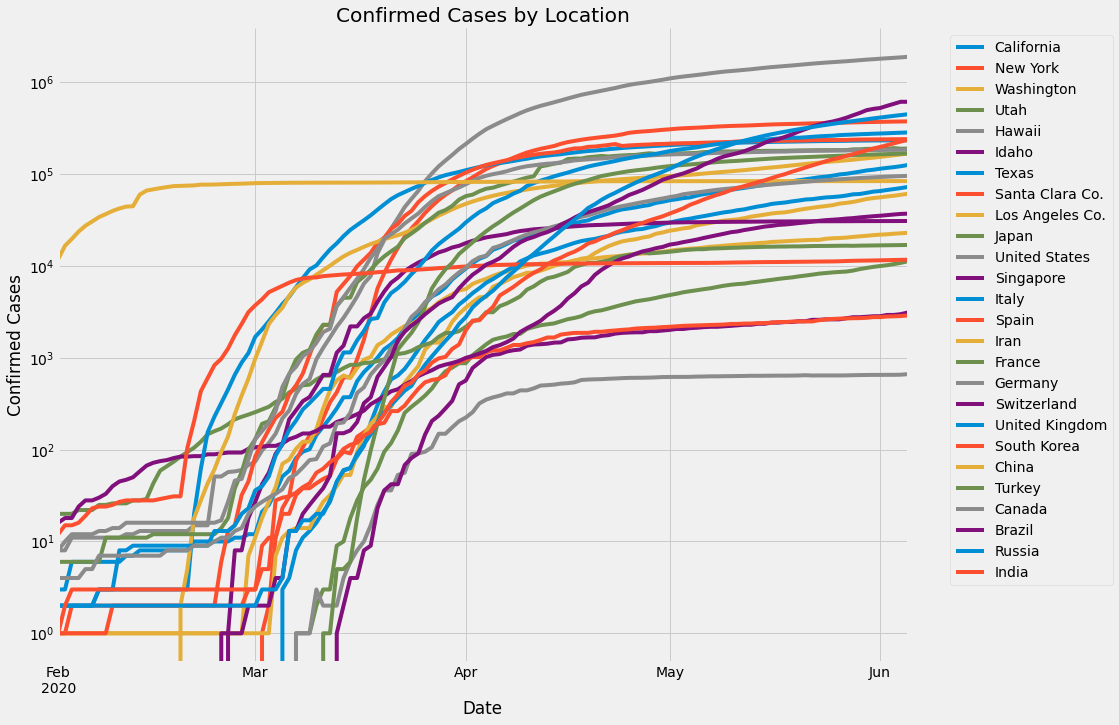

In [24]:
#newdf.loc['2/1/20':,:].plot(logy=True)
df.plot(logy=True)
plt.legend(bbox_to_anchor=(1.25, 1))
plt.tight_layout()
plt.title("Confirmed Cases by Location")
plt.ylabel("Confirmed Cases")
sns.despine()

# TEMP ONLY
Drop rows that have data glitches

In [25]:
#df = df.drop(labels=['3/22/20', '3/30/20'], axis=0)

# Graph raw data

### label_lines routine

In [26]:
def label_lines(df, ax, tuple_selector=None, print_value=False, font_family='sans-serif', font_size=14):
    '''Labels lines in a chart assuming that some lines will be different lengths than others
       If tuple_selector is set to an integer, use it as an index to the label'''
    texts = []
    for label, series in df.items():
        prev_x = series.index[0]
        prev_data = series.iloc[0]
        for index, data in series.items():
            if pd.isnull(data):
                break
            prev_x = index
            prev_data = data
        if not (tuple_selector is None):
            if print_value:
                label = '{} ({:,})'.format(label[tuple_selector], int(prev_data))
            else:
                label = label[tuple_selector]
        else:
            if print_value:
                label = '{} ({:,})'.format(label, int(prev_data))
        this_annotation = ax.annotate(label, (prev_x, prev_data),
                            xytext=(10,0), 
                            textcoords='offset pixels',
                            family=font_family, fontsize=font_size, color='darkslategrey')
        texts.append(this_annotation)
    #adjust_text(texts)

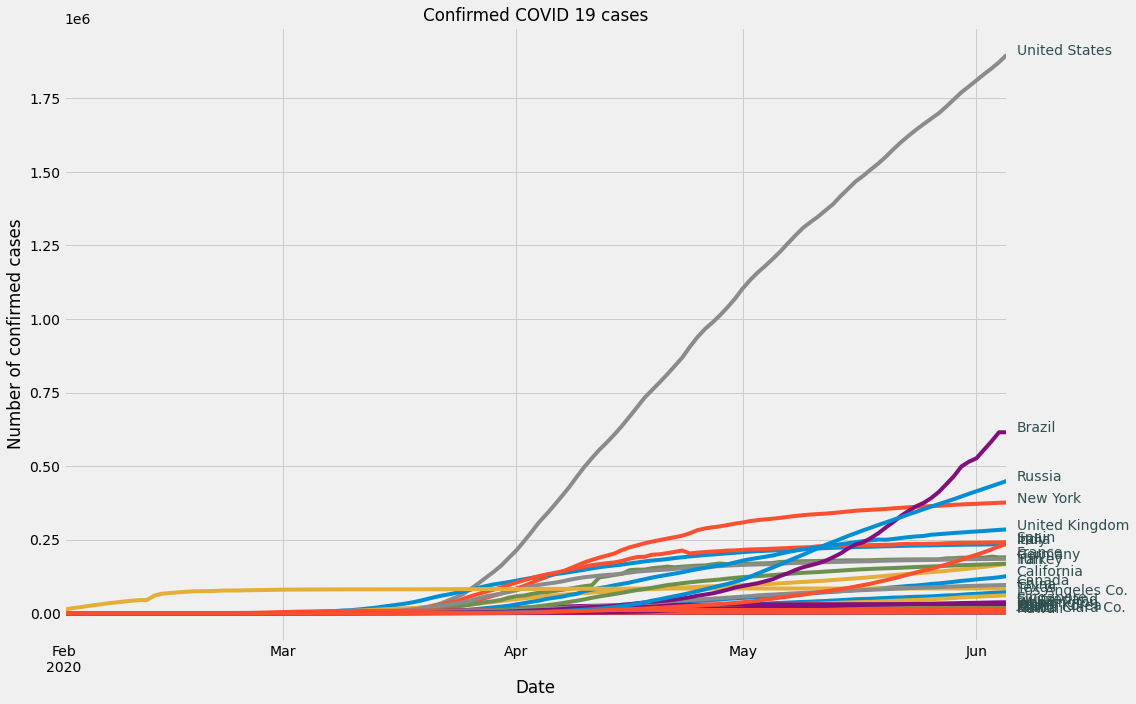

In [27]:
  
graph_data = df.loc['2020-02':,:]
#graph_data = df.drop('China', axis=1).loc['2/21/20':,:]
ax = graph_data.plot(legend=False)
ax.set_title('Confirmed COVID 19 cases', fontsize='large')
ax.set_ylabel('Number of confirmed cases', fontsize='large')
label_lines(graph_data, ax)
plt.tight_layout()
plt.show()
fig = ax.get_figure()
fig.savefig('raw.png')

# Create a 'days since 100 cases' graph

In [28]:
df.tail(2)

,California,New York,Washington,Utah,Hawaii,Idaho,Texas,Santa Clara Co.,Los Angeles Co.,Japan,...,Germany,Switzerland,United Kingdom,South Korea,China,Turkey,Canada,Brazil,Russia,India
Date,,,,,,,,,,,,,,,,,,,,,
2020-06-04,122168.0,375133.0,22729.0,10813.0,655.0,2990.0,70555.0,2850.0,59692.0,16911.0,...,184472.0,30913.0,283079.0,11668.0,84171.0,167410.0,95269.0,614941.0,440538.0,226713.0
2020-06-05,125738.0,376208.0,22993.0,11252.0,664.0,3111.0,72548.0,2892.0,61068.0,16958.0,...,184924.0,30936.0,284734.0,11719.0,84177.0,168340.0,95947.0,614941.0,449256.0,236184.0


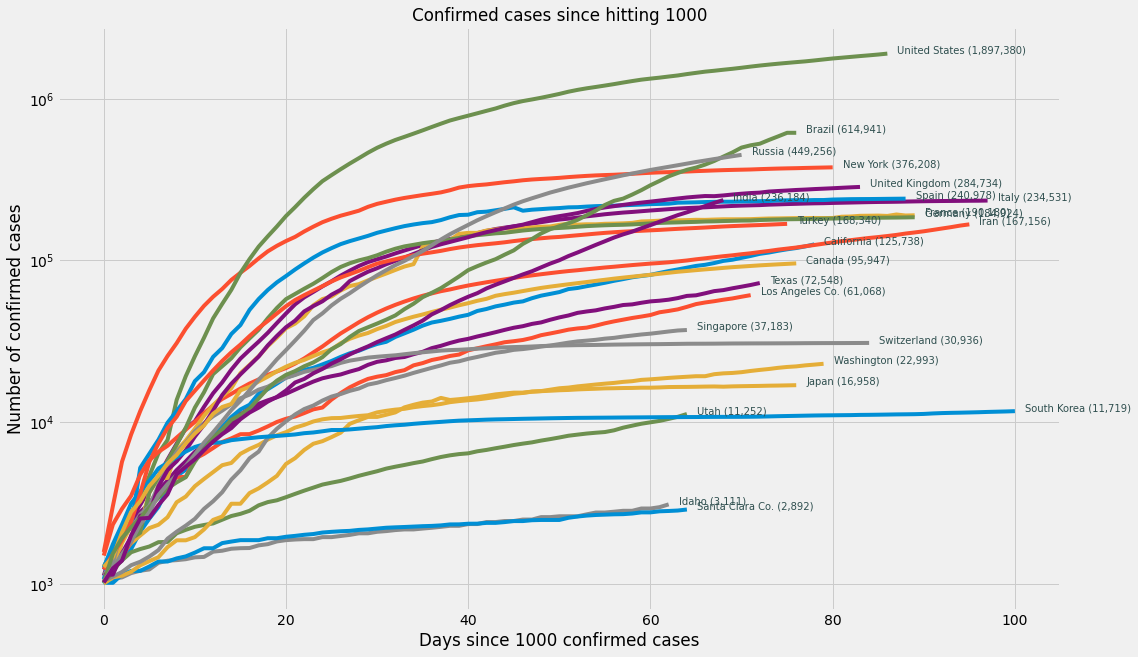

In [29]:
threshold = 1000
daysSince100 = pd.DataFrame(index=range(0,len(df.index)))
for location in df.columns:
    # create list of data once above 'threshold'
    tempList = [df.loc[date, location] 
                              for date in df[location].index 
                              if df.loc[date, location] > threshold]
    if (not tempList) or (tempList[-1] <= threshold):
        continue
    # put that list in another list that has NaN's buffered out to length of the DataFrame
    tempListFilled = list()
    for index, _ in enumerate(daysSince100.index):
        if index < len(tempList):
            tempListFilled.append(tempList[index])
        else:
            tempListFilled.append(np.NaN)
    # add the buffered list to the dataframe as a new column
    daysSince100[location] = tempListFilled

daysSince100 = daysSince100.drop('China', axis=1)
daysSince100 = daysSince100.dropna(axis=0, how='all')
ax = daysSince100.plot(logy=True, legend=False)
#ax.set_yscale('log', basey=2)
ax.set_title('Confirmed cases since hitting {}'.format(threshold), fontsize='large')
ax.set_xlabel('Days since {} confirmed cases'.format(threshold), fontsize='large')
ax.set_ylabel('Number of confirmed cases', fontsize='large')
#ax.annotate("Italy on 3/14", xy=(20,21157), xytext=(15, 30000),
#            arrowprops=dict(facecolor='grey', shrink=0.05),)

label_lines(daysSince100, ax, print_value=True, font_size=10)
    
#ax.hlines(60461826, 0, 50, linestyles='dotted', label='Pop of Italy')
plt.show()
fig = ax.get_figure()
fig.savefig('since100.png')

# Cases relative to Population

In [30]:
per = 100000

popdf = pd.DataFrame(index = df.index,
                     data = {
                         'California': 39747267,
                         'New York': 19491339,
                         'Washington': 7797095,
                         'Utah': 3282115,
                         'Hawaii': 1412687,
                         'Idaho': 1826156,
                         'Texas': 29472295,
                         'Santa Clara Co.': 2200000,
                         'Los Angeles Co.': 10500000,
                         'Japan': 126476461,
                         'United States': 331002651,
                         'Singapore': 5850342,
                         'Italy': 60461826,
                         'Spain': 46754778,
                         'Iran': 83992949,
                         'France': 65273511,
                         'Germany': 83783942,
                         'Switzerland': 8654622,
                         'United Kingdom': 67886011,
                         'South Korea': 51269185,
                         'Taiwan': 23816775,
                         'Philippines': 109581078,
                         'Ireland': 4937786,
                         'China': 1439323776,
                         'Turkey': 84339067,
                         'Belgium': 11589623,
                         'Netherlands': 17134872,
                         'Canada': 37742154,
                         'Brazil': 212559417,
                         'India': 1380004385,
                         'Indonesia': 273523615,
                         'Pakistan': 220892340,
                         'Nigeria': 206139589,
                         'Russia': 145934462,
                         
                     }

)
popdf

casesperdf = df.div(popdf).mul(per)
casesperdf.tail()

,Belgium,Brazil,California,Canada,China,France,Germany,Hawaii,Idaho,India,...,South Korea,Spain,Switzerland,Taiwan,Texas,Turkey,United Kingdom,United States,Utah,Washington
Date,,,,,,,,,,,,,,,,,,,,,
2020-06-01,NaN,247.670514,288.656324,247.171902,5.846773,290.083982,219.127909,46.153182,155.463170,14.374592,...,22.510598,512.542269,356.699576,NaN,222.558169,195.364978,409.121107,547.131570,304.651117,281.861386
2020-06-02,NaN,261.283649,294.900779,248.949755,5.847260,288.708233,219.468069,46.223969,160.610594,15.013793,...,22.606172,513.171082,356.734240,NaN,228.383979,196.296931,411.560491,553.415809,310.836153,284.169938
2020-06-03,NaN,274.754235,300.267186,250.756753,5.847190,294.652451,219.756908,46.223969,160.610594,15.711834,...,22.682241,514.013776,356.953776,NaN,233.700837,197.324924,414.326893,559.367121,319.824260,288.363807
2020-06-04,NaN,289.303108,307.362013,252.420675,5.847955,290.422557,220.175842,46.365543,163.731905,16.428426,...,22.758310,514.728142,357.184866,NaN,239.394319,198.496386,416.991654,565.753777,329.452198,291.506003
2020-06-05,NaN,289.303108,316.343763,254.217075,5.848371,291.358619,220.715325,47.002627,170.357845,17.114728,...,22.857785,515.408286,357.450620,NaN,246.156602,199.599078,419.429564,573.221995,342.827719,294.891880


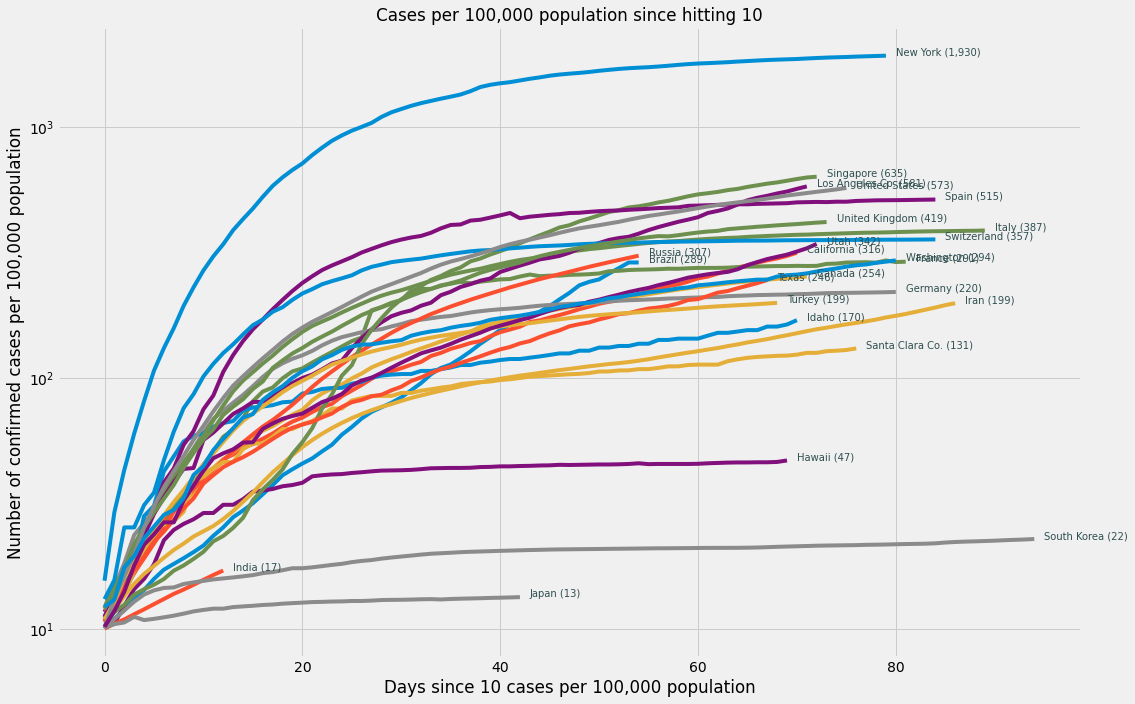

In [31]:
threshold = 10
daysSincerate = pd.DataFrame(index=range(0,len(casesperdf.index)))
for location in casesperdf.columns:
    # create list of data once above 'threshold'
    tempList = [casesperdf.loc[date, location] 
                              for date in casesperdf[location].index 
                              if casesperdf.loc[date, location] > threshold]
    if (not tempList) or (tempList[-1] <= threshold):
        continue
    # put that list in another list that has NaN's buffered out to length of the DataFrame
    tempListFilled = list()
    for index, _ in enumerate(daysSincerate.index):
        if index < len(tempList):
            tempListFilled.append(tempList[index])
        else:
            tempListFilled.append(np.NaN)
    # add the buffered list to the dataframe as a new column
    daysSincerate[location] = tempListFilled


#daysSincerate = daysSincerate.drop(['China','Singapore'], axis=1)
daysSincerate = daysSincerate.dropna(axis=0, how='all')
ax = daysSincerate.plot(logy=True, legend=False)
#ax.set_yscale('log', basey=2)
ax.set_title('Cases per {:,} population since hitting {}'.format(per, threshold), fontsize='large')
ax.set_xlabel('Days since {} cases per {:,} population'.format(threshold, per), fontsize='large')
ax.set_ylabel('Number of confirmed cases per {:,} population'.format(per), fontsize='large')
#ax.annotate("Italy on 3/14", xy=(16,34.99), xytext=(25, 24),
#            arrowprops=dict(facecolor='grey', shrink=0.05),)

label_lines(daysSincerate, ax, print_value=True, font_size=10)

plt.tight_layout()
plt.show()
fig = ax.get_figure()
fig.savefig('pop-adjusted.png')

In [32]:
daysSincerate

,Brazil,California,Canada,France,Germany,Hawaii,Idaho,India,Iran,Italy,...,Singapore,South Korea,Spain,Switzerland,Texas,Turkey,United Kingdom,United States,Utah,Washington
0,10.440375,11.716529,10.709511,10.238456,11.048657,10.547276,11.225766,10.038809,10.715185,12.197779,...,10.785694,10.115238,11.190300,13.160598,10.677825,10.928506,12.026042,10.054300,10.206833,12.248151
1,11.022800,12.818491,12.405227,11.819496,14.712843,10.547276,12.813801,10.503590,11.995054,15.169902,...,11.674531,10.963701,13.669191,15.702592,12.924002,12.837467,14.200275,13.251253,11.821645,13.107446
2,11.884677,14.723025,14.773932,13.978105,18.285127,12.387741,15.387513,10.926994,13.529707,16.785798,...,12.512089,11.874579,16.678509,25.419943,14.776589,16.043573,17.399756,16.291410,14.106757,17.621948
3,13.323333,17.958467,16.639220,16.806205,23.689504,14.440566,18.618344,11.455471,15.154844,20.611352,...,13.708600,12.859576,21.264137,25.419943,17.199204,18.590436,21.720233,19.892288,17.945745,19.545741
4,14.313645,20.655508,19.601425,19.545448,26.512240,15.856308,28.201315,11.984455,16.594250,24.995937,...,14.426507,13.733396,25.126844,31.197203,19.455560,21.502491,25.501572,25.327894,21.693329,22.995744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,22.510598,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,22.606172,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,22.682241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,22.758310,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Look at growth factor changes

In [33]:
start_date = '3/22/20'
location = ['California', 'Italy', 'New York']
#location = ['California', 'South Korea', 'Italy', 'Germany', 'New York']
df.loc[start_date:,:]

,California,New York,Washington,Utah,Hawaii,Idaho,Texas,Santa Clara Co.,Los Angeles Co.,Japan,...,Germany,Switzerland,United Kingdom,South Korea,China,Turkey,Canada,Brazil,Russia,India
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-22,1646.0,15800.0,1997.0,162.0,53.0,42.0,643.0,263.0,407.0,1101.0,...,24873.0,7474.0,5745.0,8961.0,81435.0,1236.0,1469.0,1546.0,367.0,396.0
2020-03-23,2108.0,20884.0,2221.0,252.0,56.0,68.0,758.0,302.0,536.0,1128.0,...,29056.0,8795.0,6726.0,8961.0,81498.0,1529.0,2088.0,1924.0,438.0,499.0
2020-03-24,2538.0,25681.0,2328.0,293.0,90.0,81.0,955.0,375.0,662.0,1193.0,...,32986.0,9877.0,8164.0,9037.0,81591.0,1872.0,2790.0,2247.0,495.0,536.0
2020-03-25,2998.0,30841.0,2591.0,335.0,91.0,91.0,1229.0,459.0,812.0,1307.0,...,37323.0,10897.0,9640.0,9137.0,81661.0,2433.0,3251.0,2554.0,658.0,657.0
2020-03-26,3899.0,37877.0,3207.0,388.0,95.0,146.0,1563.0,542.0,1229.0,1387.0,...,43938.0,11811.0,11812.0,9241.0,81782.0,3629.0,4042.0,2985.0,840.0,727.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-01,114733.0,371711.0,21977.0,9999.0,652.0,2839.0,65593.0,2776.0,56011.0,16787.0,...,183594.0,30871.0,277736.0,11541.0,84154.0,164769.0,93288.0,526447.0,414328.0,198370.0
2020-06-02,117215.0,373040.0,22157.0,10202.0,653.0,2933.0,67310.0,2819.0,57219.0,16837.0,...,183879.0,30874.0,279392.0,11590.0,84161.0,165555.0,93959.0,555383.0,423186.0,207191.0
2020-06-03,119348.0,374085.0,22484.0,10497.0,653.0,2933.0,68877.0,2832.0,58261.0,16867.0,...,184121.0,30893.0,281270.0,11629.0,84160.0,166422.0,94641.0,584016.0,431715.0,216824.0


In [34]:
# calculate growth factor (diff between 2 points divided by the diff between the prior 2 points)
df.loc[start_date:,:].diff().pct_change().add(1)

,California,New York,Washington,Utah,Hawaii,Idaho,Texas,Santa Clara Co.,Los Angeles Co.,Japan,...,Germany,Switzerland,United Kingdom,South Korea,China,Turkey,Canada,Brazil,Russia,India
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-24,0.930736,0.943548,0.477679,0.455556,11.333333,0.500000,1.713043,1.871795,0.976744,2.407407,...,0.939517,0.819076,1.465851,inf,1.476190,1.170648,1.134087,0.854497,0.802817,0.359223
2020-03-25,1.069767,1.075672,2.457944,1.024390,0.029412,0.769231,1.390863,1.150685,1.190476,1.753846,...,1.103562,0.942699,1.026426,1.315789,0.752688,1.635569,0.656695,0.950464,2.859649,3.270270
2020-03-26,1.958696,1.363566,2.342205,1.261905,4.000000,5.500000,1.218978,0.988095,2.780000,0.701754,...,1.525248,0.896078,1.471545,1.040000,1.728571,2.131907,1.715835,1.403909,1.116564,0.578512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-01,1.353113,0.847748,0.779037,0.765152,0.000000,0.000000,0.475974,0.000000,0.804781,1.028571,...,0.832579,0.529412,0.815694,1.085714,0.444444,0.985697,1.013784,0.706807,0.915516,0.883739
2020-06-02,0.892164,1.412327,0.654545,1.004950,inf,inf,1.824655,inf,1.196040,1.388889,...,1.548913,0.333333,1.048101,1.289474,0.875000,0.950423,0.829419,2.494913,1.043960,1.136580
2020-06-03,0.859388,0.786305,1.816667,1.453202,0.000000,0.000000,0.912638,0.302326,0.862583,0.600000,...,0.849123,6.333333,1.134058,0.795918,-0.142857,1.103053,1.016393,0.989529,0.962858,1.092053


In [35]:
# Many countries didn't update their reports on 3/12 leading to 'inf' growth
# factor on 3/13.  I'm going to drop 3/12 data to get a better trend
#tempdf = df.drop('3/12/20', axis='index')
tempdf = df
tempdf.loc[start_date:,:].diff().pct_change().add(1)

,California,New York,Washington,Utah,Hawaii,Idaho,Texas,Santa Clara Co.,Los Angeles Co.,Japan,...,Germany,Switzerland,United Kingdom,South Korea,China,Turkey,Canada,Brazil,Russia,India
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-24,0.930736,0.943548,0.477679,0.455556,11.333333,0.500000,1.713043,1.871795,0.976744,2.407407,...,0.939517,0.819076,1.465851,inf,1.476190,1.170648,1.134087,0.854497,0.802817,0.359223
2020-03-25,1.069767,1.075672,2.457944,1.024390,0.029412,0.769231,1.390863,1.150685,1.190476,1.753846,...,1.103562,0.942699,1.026426,1.315789,0.752688,1.635569,0.656695,0.950464,2.859649,3.270270
2020-03-26,1.958696,1.363566,2.342205,1.261905,4.000000,5.500000,1.218978,0.988095,2.780000,0.701754,...,1.525248,0.896078,1.471545,1.040000,1.728571,2.131907,1.715835,1.403909,1.116564,0.578512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-01,1.353113,0.847748,0.779037,0.765152,0.000000,0.000000,0.475974,0.000000,0.804781,1.028571,...,0.832579,0.529412,0.815694,1.085714,0.444444,0.985697,1.013784,0.706807,0.915516,0.883739
2020-06-02,0.892164,1.412327,0.654545,1.004950,inf,inf,1.824655,inf,1.196040,1.388889,...,1.548913,0.333333,1.048101,1.289474,0.875000,0.950423,0.829419,2.494913,1.043960,1.136580
2020-06-03,0.859388,0.786305,1.816667,1.453202,0.000000,0.000000,0.912638,0.302326,0.862583,0.600000,...,0.849123,6.333333,1.134058,0.795918,-0.142857,1.103053,1.016393,0.989529,0.962858,1.092053


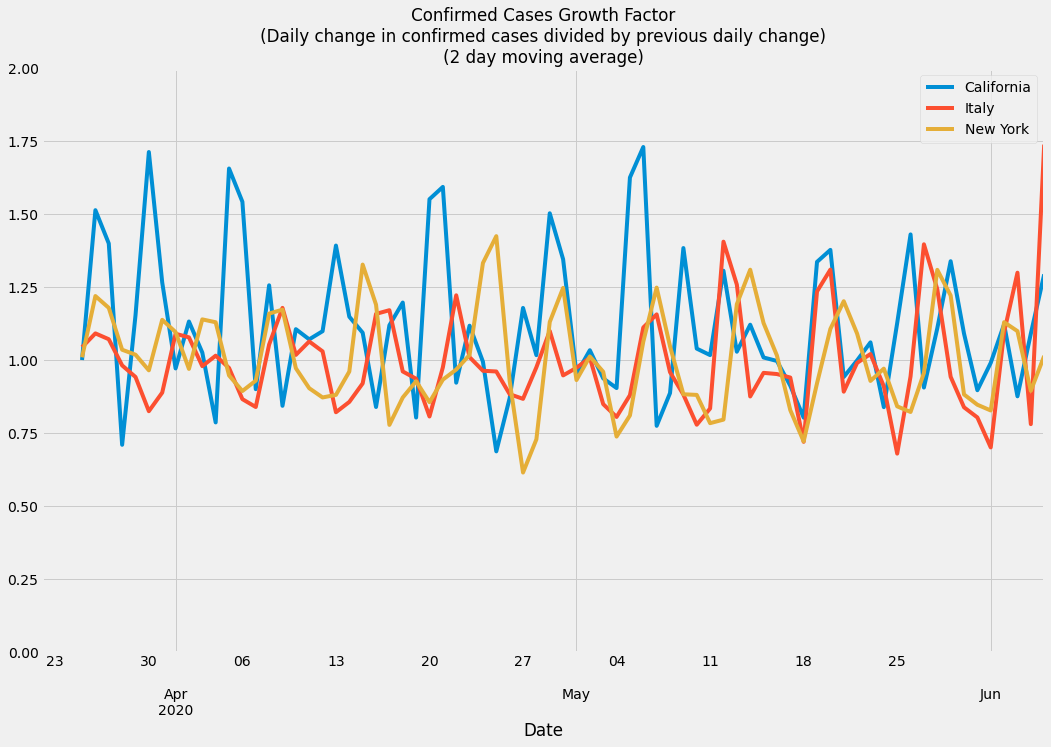

In [36]:
# graph the growth factors
window = 2
ax = tempdf.loc[start_date:,location].diff().pct_change().add(1).rolling(window).mean().plot()
ax.set_ylim(ymin=0, ymax=2)
ax.set_title("Confirmed Cases Growth Factor\n(Daily change in confirmed cases divided by previous daily change)\n({} day moving average)".format(window), fontsize='large')
fig = ax.get_figure()
fig.savefig('growth_factors.png')